<h1 style="text-align: center;">Preprocesamiento de los datos</h1>
<h2 style="text-align: center;">Camilo Esteban Zambrano Pereira</h2>
<h2 style="text-align: center;">Visión de máquina</h2>

# Librerias
---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm
import os
import glob
import tensorflow as tf
import re
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from skimage.segmentation import watershed

2023-10-25 20:27:19.987480: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-25 20:27:19.987514: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-25 20:27:19.987542: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-25 20:27:19.991827: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/tmp/ipykernel_9971/3658870232.py:10: DeprecationW

# Carga de datos
---

In [2]:
df = pd.read_csv("../../data/train.csv")
df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


# Ajustes en el dataset
---

Extracción de la ruta y la información contenida en este

In [3]:
def parse_int(s):
    i = j = 0
    while i < len(s):
        while j < len(s) and s[j].isdigit():
            j += 1
        if i < j:
            return int(s[i:j])
        i = j = j + 1
    return math.nan

def extract_image_info(path):
    case_day, fname = path.rsplit("/", maxsplit=3)[1::2]
    case, day = case_day.split("_")
    slice, height, width = fname.split("_", maxsplit=4)[1:4]
    info = [f"{case}_{day}_slice_{slice}"]
    numeric_info = [case, day, slice, height, width]
    info.extend([parse_int(info) for info in numeric_info])
    return info
    
def create_image_df(path):
    paths = glob.glob(f"{TRAIN_DIR}/**/*.png", recursive=True)
    df = pd.DataFrame({"path": paths})
    info_cols = ["id", "case", "day", "slice", "height", "width"]
    df[info_cols] = df.apply(
        lambda row: extract_image_info(row.path), 
        axis=1,
        result_type="expand"
    )
    return df

TRAIN_DIR = "../../data/train"
data = create_image_df(TRAIN_DIR)
data

,path,id,case,day,slice,height,width
0,../../data/train/case110/case110_day12/scans/s...,case110_day12_slice_0002,110,12,2,360,310
1,../../data/train/case110/case110_day12/scans/s...,case110_day12_slice_0023,110,12,23,360,310
2,../../data/train/case110/case110_day12/scans/s...,case110_day12_slice_0042,110,12,42,360,310
3,../../data/train/case110/case110_day12/scans/s...,case110_day12_slice_0040,110,12,40,360,310
4,../../data/train/case110/case110_day12/scans/s...,case110_day12_slice_0129,110,12,129,360,310
...,...,...,...,...,...,...,...
38491,../../data/train/case65/case65_day28/scans/sli...,case65_day28_slice_0131,65,28,131,266,266
38492,../../data/train/case65/case65_day28/scans/sli...,case65_day28_slice_0054,65,28,54,266,266
38493,../../data/train/case65/case65_day28/scans/sli...,case65_day28_slice_0085,65,28,85,266,266
38494,../../data/train/case65/case65_day28/scans/sli...,case65_day28_slice_0027,65,28,27,266,266


Modificación del dataset para tener ids unicos manejando las mascaras como columnas

In [4]:
def create_mask_df(df):
    df = df.set_index(["id", "class"]).unstack().reset_index()
    df.columns = "id", 'large_bowel', 'small_bowel', 'stomach'
    df.fillna("", inplace=True)
    df["mask"] = ""
    df["segmented"] = 0
    return df

segmentation = create_mask_df(df)
data = segmentation.merge(data, on="id", how="left")
data

,id,large_bowel,small_bowel,stomach,mask,segmented,path,case,day,slice,height,width
0,case101_day20_slice_0001,,,,,0,../../data/train/case101/case101_day20/scans/s...,101,20,1,266,266
1,case101_day20_slice_0002,,,,,0,../../data/train/case101/case101_day20/scans/s...,101,20,2,266,266
2,case101_day20_slice_0003,,,,,0,../../data/train/case101/case101_day20/scans/s...,101,20,3,266,266
3,case101_day20_slice_0004,,,,,0,../../data/train/case101/case101_day20/scans/s...,101,20,4,266,266
4,case101_day20_slice_0005,,,,,0,../../data/train/case101/case101_day20/scans/s...,101,20,5,266,266
...,...,...,...,...,...,...,...,...,...,...,...,...
38491,case9_day22_slice_0140,,,,,0,../../data/train/case9/case9_day22/scans/slice...,9,22,140,360,310
38492,case9_day22_slice_0141,,,,,0,../../data/train/case9/case9_day22/scans/slice...,9,22,141,360,310
38493,case9_day22_slice_0142,,,,,0,../../data/train/case9/case9_day22/scans/slice...,9,22,142,360,310
38494,case9_day22_slice_0143,,,,,0,../../data/train/case9/case9_day22/scans/slice...,9,22,143,360,310


# Preprocesamiento
---

## Mascaras

Generación y guardado de las máscaras

<h1 style="color: red; font-size: 40px;">NO EJECUTAR ESTA CELDA</h1>
Esta celda hace genera las 38.496 imagenes. El proceso tarda varios minutos.

In [8]:
def generate_mask(seg, shape):
    # En caso de que no exista segmentación, se devuelve una imagen vacia
    if seg == "":
        mask = np.zeros(np.prod(shape), dtype=np.uint8)
        mask = np.reshape(mask, shape)
        return mask
    # Se toman los valores con saltos de 2 desde el 0, representan el origen
    start_list = seg[0::2]
    # Se toman los valores con saltos de 2 desde el 1, representan la longitud
    length_list = seg[1::2]
    mask = np.zeros(np.prod(shape), dtype=np.uint8)
    for start, length in zip(start_list, length_list):
        start = int(start)
        length = int(length)
        mask[start:start + length] = 255
    # Se ajusta la forma de la imagen para que pase de un vector a una matriz
    mask = np.reshape(mask, shape)
    mask = np.ma.masked_where(mask == 0, mask)
    return mask

def save_mask(data):
    for i in tqdm(range(data.shape[0])):
        temp_path = data.iloc[i, 6]
        shape = (data["width"].iloc[i], data["height"].iloc[i])
        seg_dir = temp_path.replace("train", "masks")
        
        seg1 = data.iloc[i, 1].split()
        seg2 = data.iloc[i, 2].split()
        seg3 = data.iloc[i, 3].split()
        
        if seg1!=[] or seg2!=[] or seg3!=[]:
            data.iloc[i, 5] = 1
        
        mask1 = generate_mask(seg1, shape)
        mask1 = cv2.resize(mask1, (266, 266))
        mask2 = generate_mask(seg2, shape)
        mask2 = cv2.resize(mask2, (266, 266))
        mask3 = generate_mask(seg3, shape)
        mask3 = cv2.resize(mask3, (266, 266))
        mask4 = np.ones(mask1.shape)*255
        mask4 = mask4-mask1
        mask4 = mask4-mask2
        mask4 = mask4-mask3
        
        # Se juntan las mascaras en una sola imagen

        #r=large_bowel
        #g=small_bowel
        #b=stomach
        mask = np.dstack((mask1, mask2, mask3, mask4))
        
        # Se guarda la imagen en la dirección de destino
        os.makedirs(os.path.dirname(seg_dir), exist_ok=True)
        cv2.imwrite(seg_dir, mask)
        data.iloc[i, 4] = seg_dir
        
    return data
data = save_mask(data)
data

100%|██████████| 38496/38496 [01:24<00:00, 456.69it/s]


,id,large_bowel,small_bowel,stomach,mask,segmented,path,case,day,slice,height,width
0,case101_day20_slice_0001,,,,../../data/masks/case101/case101_day20/scans/s...,0,../../data/train/case101/case101_day20/scans/s...,101,20,1,266,266
1,case101_day20_slice_0002,,,,../../data/masks/case101/case101_day20/scans/s...,0,../../data/train/case101/case101_day20/scans/s...,101,20,2,266,266
2,case101_day20_slice_0003,,,,../../data/masks/case101/case101_day20/scans/s...,0,../../data/train/case101/case101_day20/scans/s...,101,20,3,266,266
3,case101_day20_slice_0004,,,,../../data/masks/case101/case101_day20/scans/s...,0,../../data/train/case101/case101_day20/scans/s...,101,20,4,266,266
4,case101_day20_slice_0005,,,,../../data/masks/case101/case101_day20/scans/s...,0,../../data/train/case101/case101_day20/scans/s...,101,20,5,266,266
...,...,...,...,...,...,...,...,...,...,...,...,...
38491,case9_day22_slice_0140,,,,../../data/masks/case9/case9_day22/scans/slice...,0,../../data/train/case9/case9_day22/scans/slice...,9,22,140,360,310
38492,case9_day22_slice_0141,,,,../../data/masks/case9/case9_day22/scans/slice...,0,../../data/train/case9/case9_day22/scans/slice...,9,22,141,360,310
38493,case9_day22_slice_0142,,,,../../data/masks/case9/case9_day22/scans/slice...,0,../../data/train/case9/case9_day22/scans/slice...,9,22,142,360,310
38494,case9_day22_slice_0143,,,,../../data/masks/case9/case9_day22/scans/slice...,0,../../data/train/case9/case9_day22/scans/slice...,9,22,143,360,310


## Imágenes base

Dado que las imágenes presentan condiciones muy distintas entre ellas, es dificil establecer una metodología para extraer caracteristicas comunes de todas las imágenes

In [6]:
# Función de visualización
def plot_preprocess(image, new_image, mask):
    mask = cv2.resize(mask, (266, 266))
    image = cv2.resize(image, (266, 266))
    plt.figure()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
    ax1.imshow(image, cmap='bone')
    ax1.set_title("Imagen")
    ax2.imshow(new_image, cmap='bone')
    ax2.set_title("Imagen Procesada")
    ax3.imshow(new_image, cmap='bone')
    ax3.imshow(mask, alpha=0.5)
    ax3.set_title("Segmentación")
    ax1.axis("off")
    ax2.axis("off")
    ax3.axis("off")

In [65]:
def Procesamiento_hounsfield(img): 
    img = cv2.resize(img, (266, 266))
    img = (img/2).astype("float32")
    img = np.where(img>2000, 0, img)
    img = np.where(img<1000, 0, img)
    img = cv2.GaussianBlur(img,(7,7),0)
    return img

In [66]:
def lee_filter(img, size):
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance**2 / (img_variance**2 + overall_variance**2)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output
def Procesamiento_bordes(img): 
    img = cv2.resize(img, (266, 266))
    img = cv2.normalize(img, None, 0, 255, norm_type=cv2.NORM_MINMAX)
    img = cv2.medianBlur(img,3)
    img = (img).astype("uint8")
    lee_filter(img, 15)
    img = cv2.Canny(img, 50, 100, apertureSize = 3, L2gradient = True)
    kernel = np.ones((2,2),np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel, iterations=1)
    img = cv2.dilate(img, kernel, iterations=1)
    segmentation = watershed(img)
    segmentation = np.float32(segmentation)
    segmentation = img - cv2.GaussianBlur(segmentation,(3,3),0)
    segmentation = cv2.dilate(segmentation, kernel, iterations = 1)
    segmentation = abs(segmentation)
    return segmentation

In [67]:
def Procesamiento_apiladas(img1, img2, img3): 
    img1 = cv2.resize(img1, (266, 266))
    #img1 = cv2.normalize(img1, None, 0, 255, norm_type=cv2.NORM_MINMAX)
    img2 = cv2.resize(img2, (266, 266))
    #img2 = cv2.normalize(img2, None, 0, 255, norm_type=cv2.NORM_MINMAX)
    img3 = cv2.resize(img3, (266, 266))
    #img3 = cv2.normalize(img3, None, 0, 255, norm_type=cv2.NORM_MINMAX)
    img = np.dstack((img1, img2, img3))
    img = cv2.normalize(img, None, 0, 255, norm_type=cv2.NORM_MINMAX)
    return img

<Figure size 640x480 with 0 Axes>

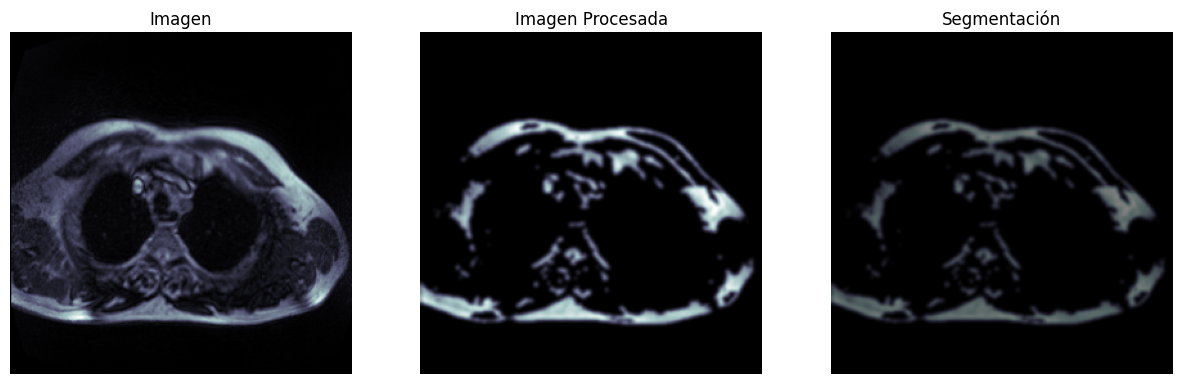

<Figure size 640x480 with 0 Axes>

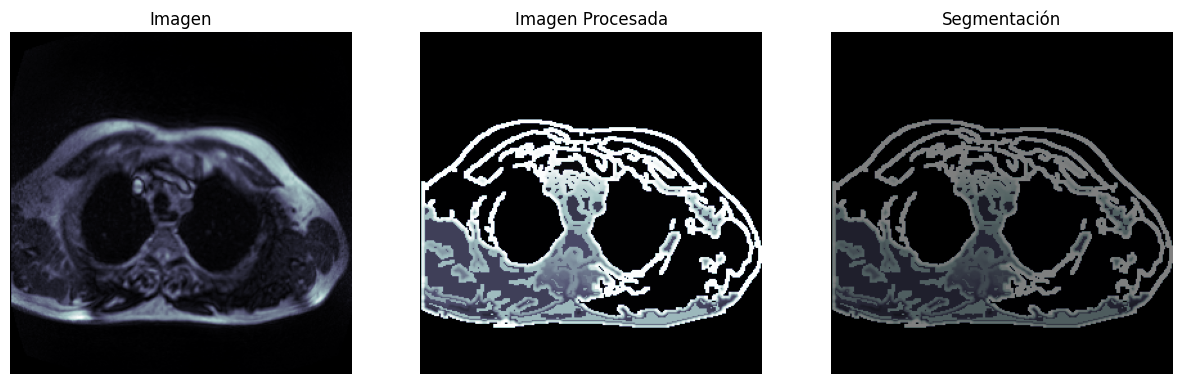

<Figure size 640x480 with 0 Axes>

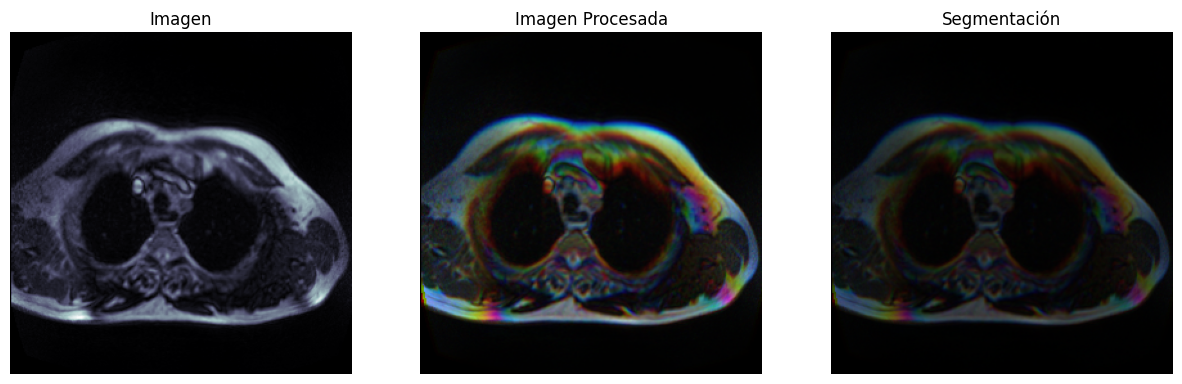

In [68]:
test_image = data.sample(1)["path"].values[0]
test_mask = test_image.replace("train", "masks")
case_slice = int(test_image.split("_")[2])
test_image2 = test_image.replace(str(case_slice), str(case_slice+2))
test_image3 = test_image.replace(str(case_slice), str(case_slice+4))
img = cv2.imread(test_image, cv2.IMREAD_ANYDEPTH)
img2 = cv2.imread(test_image2, cv2.IMREAD_ANYDEPTH)
img3 = cv2.imread(test_image3, cv2.IMREAD_ANYDEPTH)
mask = cv2.imread(test_mask, cv2.IMREAD_COLOR)
hu = Procesamiento_hounsfield(img)
bounds = Procesamiento_bordes(img)
stack = Procesamiento_apiladas(img, img2, img3)
plot_preprocess(img, hu, mask)
plot_preprocess(img, bounds, mask)
plot_preprocess(img, stack, mask)

In [69]:
np.unique(Procesamiento_apiladas(img, img2, img3))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

Se crea el dataset para las imagenes apiladas, hay un salto de 2 imagenes para dar mayor variación

In [70]:
channels=3
stride=2
for i in range(channels):
    data[f'image_path_{i:02}'] = data.groupby(['case','day'])['path'].shift(-i*stride).fillna(method="ffill")
data['image_paths'] = data[[f'image_path_{i:02d}' for i in range(channels)]].values.tolist()
data

,id,large_bowel,small_bowel,stomach,mask,segmented,path,case,day,slice,height,width,image_path_00,image_path_01,image_path_02,image_paths
0,case101_day20_slice_0001,,,,../../data/masks/case101/case101_day20/scans/s...,0,../../data/train/case101/case101_day20/scans/s...,101,20,1,266,266,../../data/train/case101/case101_day20/scans/s...,../../data/train/case101/case101_day20/scans/s...,../../data/train/case101/case101_day20/scans/s...,[../../data/train/case101/case101_day20/scans/...
1,case101_day20_slice_0002,,,,../../data/masks/case101/case101_day20/scans/s...,0,../../data/train/case101/case101_day20/scans/s...,101,20,2,266,266,../../data/train/case101/case101_day20/scans/s...,../../data/train/case101/case101_day20/scans/s...,../../data/train/case101/case101_day20/scans/s...,[../../data/train/case101/case101_day20/scans/...
2,case101_day20_slice_0003,,,,../../data/masks/case101/case101_day20/scans/s...,0,../../data/train/case101/case101_day20/scans/s...,101,20,3,266,266,../../data/train/case101/case101_day20/scans/s...,../../data/train/case101/case101_day20/scans/s...,../../data/train/case101/case101_day20/scans/s...,[../../data/train/case101/case101_day20/scans/...
3,case101_day20_slice_0004,,,,../../data/masks/case101/case101_day20/scans/s...,0,../../data/train/case101/case101_day20/scans/s...,101,20,4,266,266,../../data/train/case101/case101_day20/scans/s...,../../data/train/case101/case101_day20/scans/s...,../../data/train/case101/case101_day20/scans/s...,[../../data/train/case101/case101_day20/scans/...
4,case101_day20_slice_0005,,,,../../data/masks/case101/case101_day20/scans/s...,0,../../data/train/case101/case101_day20/scans/s...,101,20,5,266,266,../../data/train/case101/case101_day20/scans/s...,../../data/train/case101/case101_day20/scans/s...,../../data/train/case101/case101_day20/scans/s...,[../../data/train/case101/case101_day20/scans/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38491,case9_day22_slice_0140,,,,../../data/masks/case9/case9_day22/scans/slice...,0,../../data/train/case9/case9_day22/scans/slice...,9,22,140,360,310,../../data/train/case9/case9_day22/scans/slice...,../../data/train/case9/case9_day22/scans/slice...,../../data/train/case9/case9_day22/scans/slice...,[../../data/train/case9/case9_day22/scans/slic...
38492,case9_day22_slice_0141,,,,../../data/masks/case9/case9_day22/scans/slice...,0,../../data/train/case9/case9_day22/scans/slice...,9,22,141,360,310,../../data/train/case9/case9_day22/scans/slice...,../../data/train/case9/case9_day22/scans/slice...,../../data/train/case9/case9_day22/scans/slice...,[../../data/train/case9/case9_day22/scans/slic...
38493,case9_day22_slice_0142,,,,../../data/masks/case9/case9_day22/scans/slice...,0,../../data/train/case9/case9_day22/scans/slice...,9,22,142,360,310,../../data/train/case9/case9_day22/scans/slice...,../../data/train/case9/case9_day22/scans/slice...,../../data/train/case9/case9_day22/scans/slice...,[../../data/train/case9/case9_day22/scans/slic...
38494,case9_day22_slice_0143,,,,../../data/masks/case9/case9_day22/scans/slice...,0,../../data/train/case9/case9_day22/scans/slice...,9,22,143,360,310,../../data/train/case9/case9_day22/scans/slice...,../../data/train/case9/case9_day22/scans/slice...,../../data/train/case9/case9_day22/scans/slice...,[../../data/train/case9/case9_day22/scans/slic...


<h1 style="color: red; font-size: 40px;">NO EJECUTAR ESTA CELDA</h1>
Esta celda hace el procesamiento sobre todo el dataset, crendo 38.496 imagenes. El proceso tarda varios minutos.

In [71]:
def preprocessing():
    for i in tqdm(range(len(data))):
        new_path = re.sub("train", "preprocess", data["image_path_00"][i])
        img0 = cv2.imread(data["image_path_00"][i], cv2.IMREAD_UNCHANGED)
        img1 = cv2.imread(data["image_path_01"][i], cv2.IMREAD_UNCHANGED)
        img2 = cv2.imread(data["image_path_02"][i], cv2.IMREAD_UNCHANGED)
        
        image = Procesamiento_apiladas(img0, img1, img2)
        os.makedirs(os.path.dirname(new_path), exist_ok=True)
        cv2.imwrite(new_path, np.uint8(image))

preprocessing()

  0%|          | 0/38496 [00:00<?, ?it/s]

100%|██████████| 38496/38496 [03:32<00:00, 180.84it/s]


# Nuevo dataset
---

Creación del nuevo dataset:

In [72]:
data["path"] = data["path"].apply(lambda x: re.sub("train", "preprocess", x))
data = data[['path', 'mask', 'segmented']]
data.to_csv("../../data/ds_train.csv",index=False)
data

,path,mask,segmented
0,../../data/preprocess/case101/case101_day20/sc...,../../data/masks/case101/case101_day20/scans/s...,0
1,../../data/preprocess/case101/case101_day20/sc...,../../data/masks/case101/case101_day20/scans/s...,0
2,../../data/preprocess/case101/case101_day20/sc...,../../data/masks/case101/case101_day20/scans/s...,0
3,../../data/preprocess/case101/case101_day20/sc...,../../data/masks/case101/case101_day20/scans/s...,0
4,../../data/preprocess/case101/case101_day20/sc...,../../data/masks/case101/case101_day20/scans/s...,0
...,...,...,...
38491,../../data/preprocess/case9/case9_day22/scans/...,../../data/masks/case9/case9_day22/scans/slice...,0
38492,../../data/preprocess/case9/case9_day22/scans/...,../../data/masks/case9/case9_day22/scans/slice...,0
38493,../../data/preprocess/case9/case9_day22/scans/...,../../data/masks/case9/case9_day22/scans/slice...,0
38494,../../data/preprocess/case9/case9_day22/scans/...,../../data/masks/case9/case9_day22/scans/slice...,0


Exportar el dataset con los paths de las imágenes en formato csv

Los paths de las imágenes serán utilizados para cargar los datos en el modelado en un dataset de tensorflow.

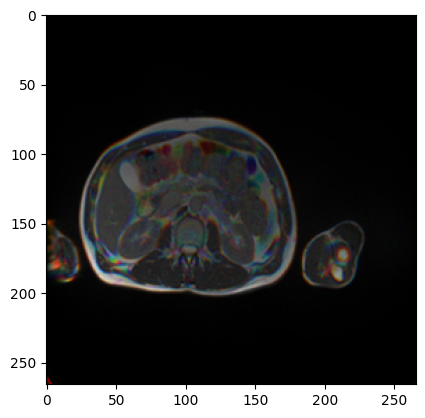

In [73]:
test = cv2.imread(data["path"].sample(1).values[0], cv2.IMREAD_UNCHANGED)
plt.imshow(test)